# Model Inference
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hsimonfroy/benchmark-field-level/blob/main/examples/infer_model.ipynb)

Infer from a cosmological model via MCMC samplers.

In [3]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.75' # NOTE: jax preallocates GPU (default 75%)
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, vmap, grad, debug, tree
jconfig.update("jax_enable_x64", True)
print(jdevices())

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload, Path

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname
#!jupyter nbconvert --to python /global/u1/h/hsimfroy/workspace/montecosmo_proj/src/montecosmo/tests/infer_model2.ipynb

save_dir = Path("/feynman/home/dphp/hs276503/scratch/png/lpt_32_fnl_00")
# save_dir = Path("/pscratch/sd/h/hsimfroy/png/lpt_64_fnl_0")
save_path = save_dir / "test"
save_dir.mkdir(parents=True, exist_ok=True)

[cuda(id=0)]
feynmangpu04.cluster.local


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
import fitsio
fits_path = Path("/home/nfs/bao/AbacusSummit_v4_2/mock0/LRG_complete_SGC_1_clustering.ran.fits")
data = fitsio.read(fits_path, columns=['RA','DEC','Z'])


## Experimental setup
### Instantiate model
We can see how the model is actually reparametrized.

###  Generate an observation and condition the model on it
We can see all the free parameters in the model, that we will subsequently sample.

Generate truth...


2025-05-29 16:48:44.827781: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Generate truth...
# CONFIG
{'a_obs': None,
 'ap_auto': True,
 'box_center': array([1365.33215673,  218.00609919,  268.40691564]),
 'box_rotvec': array([0., 0., 0.]),
 'cell_length': 12.814377496017125,
 'curved_sky': True,
 'evolution': 'lpt',
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'loc_fid': 0.3111,
                         'low': 0.05,
                         'scale': 0.5,
                         'scale_fid': 0.01},
             'alpha_ap': {'group': 'ap',
                          'high': inf,
                          'label': '{\\alpha_\\mathrm{AP}}',
                          'loc': 1.0,
                          'loc_fid': 1.0,
                          'low': 0.0,
                          'scale': 0.1,
                          'scale_fid': 0.01},
             'alpha_iso': {'group': 'ap',
                           'high'

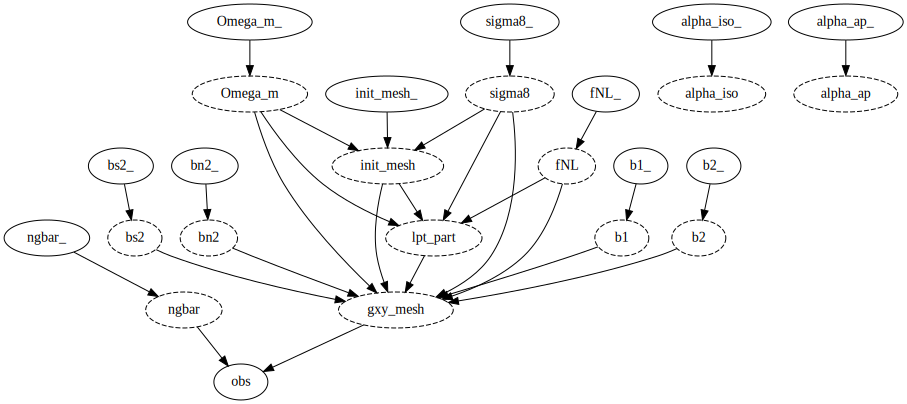

In [4]:
# overwrite = False
overwrite = True
truth0 = {'Omega_m':0.3, 
    'sigma8':0.8,
    'b1':1.,
    'b2':0., 
    'bs2':0., 
    'bn2': 0.,
    'fNL': 0.,
    'alpha_iso': 1.,
    'alpha_ap': 1.,
    'ngbar':1e-3,}
cell_budget = 256**3
padding = 0.2

if not os.path.exists(save_dir / "truth.npz") or overwrite:
    print("Generate truth...")
    model = FieldLevelModel(**default_config | 
                                {'mesh_shape': 3*(64,), 
                                'cell_length': 1., 
                                'box_center': (0.,0.,2000.), # in Mpc/h
                                'box_rotvec': (0.,0.,0.), # rotation vector in radians
                                'evolution': 'lpt',
                                'a_obs': None, # light-cone if None
                                'curved_sky': True, # curved vs. flat sky
                                'ap_auto': True, # parametrized AP vs. auto AP
                                'window': padding, # if float, padded fraction, if str or Path, path to window mesh file
                                } )
    
    # fits_path = Path("/home/nfs/bao/AbacusSummit_v4_2/mock0/LRG_complete_SGC_1_clustering.ran.fits")
    fits_path = Path("/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit_v4_2/mock0/LRG_complete_SGC_1_clustering.ran.fits")
    model.add_window(fits_path, cell_budget, padding, save_dir / "window.npy")
    
    truth = model.predict(samples=truth0, hide_base=False, hide_samp=False, hide_det=False, from_base=True)
    model.save(save_dir / "model.yaml")    
    jnp.savez(save_dir / "truth.npz", **truth)
    delta_obs  = model.count2delta(truth['obs'])

    # model2 = FieldLevelModel(**model.asdict() | {'evolution': 'kaiser', 'curved_sky':False, 'window':None})
    model2 = FieldLevelModel(**model.asdict() | {'ap_auto': False})

    truth2 = model2.predict(samples=truth0, hide_base=False, hide_samp=False, from_base=True)
    model2.save(save_dir / "model2.yaml")    
    jnp.savez(save_dir / "truth2.npz", **truth2)
    delta_obs2 = model2.count2delta(truth2['obs'])
else:
    model = FieldLevelModel.load(save_dir / "model.yaml")
    truth = np.load(save_dir / "truth.npz")
    delta_obs  = model.count2delta(truth['obs'])

    model2 = FieldLevelModel.load(save_dir / "model2.yaml")
    truth2 = np.load(save_dir / "truth2.npz")
    delta_obs2 = model2.count2delta(truth2['obs'])

print(model)
model.render()
delta_obs = model.count2delta(truth['obs'])

# print(model2)
# model2.render()
# model2.render("bnet.png")
delta_obs2 = model2.count2delta(truth2['obs'])

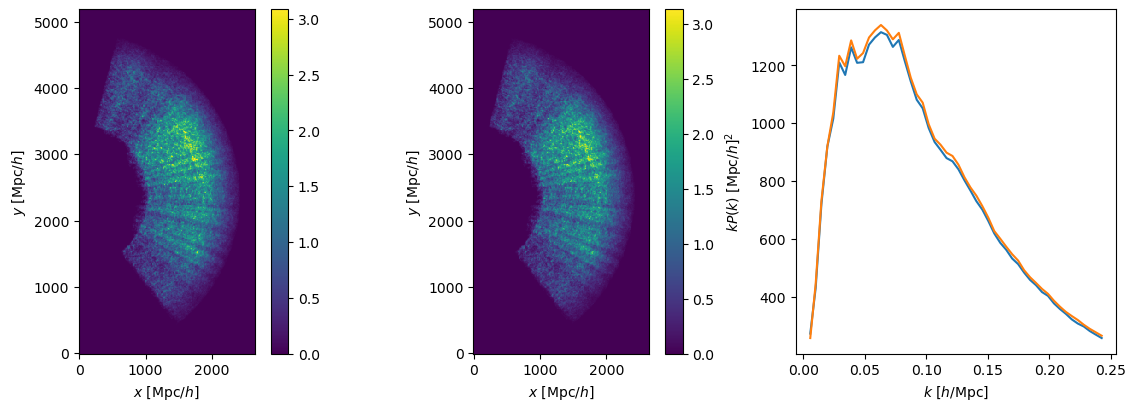

In [5]:
from montecosmo.plot import plot_mesh, plot_pow

axis = 2
ind = 1.
count_obs  = model.masked2mesh(truth['obs'])
count_obs2 = model2.masked2mesh(truth2['obs'])

plt.figure(figsize=(12, 4), layout='constrained')
plt.subplot(131)
plot_mesh(count_obs, model.box_shape, ind, axis)
plt.colorbar()

plt.subplot(132)
plot_mesh(count_obs2, model.box_shape, ind, axis)
plt.colorbar()

plt.subplot(133)
kpow = model.spectrum(delta_obs)
kpow2 = model2.spectrum(delta_obs2)
plot_pow(*kpow);
plot_pow(*kpow2);

## Perform the inference

### Warmup the field only

Warming up...
Perform 16384.0 adaptation steps


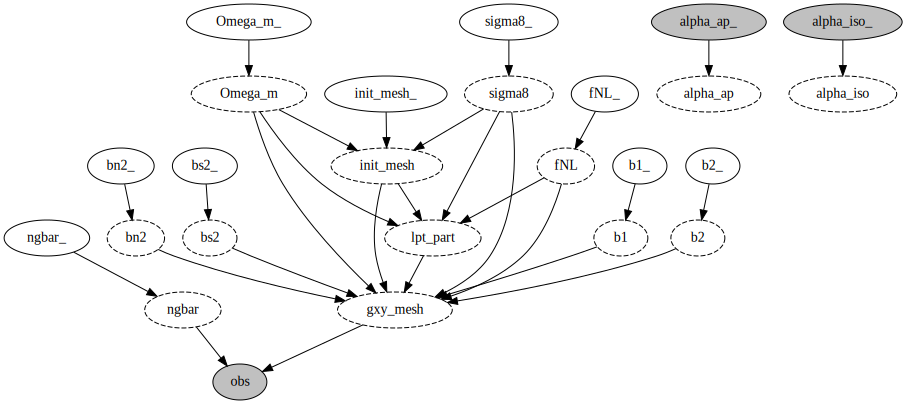

In [4]:
n_samples, n_runs, n_chains = 128, 64, 8
tune_mass = True
overwrite = True
# overwrite = False

params_init = jit(vmap(partial(model.kaiser_post, delta_obs=delta_obs, scale_field=1/10)))(jr.split(jr.key(45), n_chains))    
params_init2 = jit(vmap(partial(model2.kaiser_post, delta_obs=delta_obs2)))(jr.split(jr.key(45), n_chains))

if not os.path.exists(save_path+"_warm_state.p") or overwrite:
    print("Warming up...")
    model.reset()
    model.condition({'obs': truth['obs']} | model.loc_fid, from_base=True)
    model.block()

    from montecosmo.samplers import get_mclmc_warmup
    warmup_fn = jit(vmap(get_mclmc_warmup(model.logpdf, n_steps=2**14, config=None, 
                                desired_energy_var=1e-6, diagonal_preconditioning=False)))
    state, config = warmup_fn(jr.split(jr.key(43), n_chains), {k: params_init[k] for k in ['init_mesh_']})
    pdump(state, save_path+"_warm_state.p")
    pdump(config, save_path+"_warm_conf.p")
else:
    state = pload(save_path+"_warm_state.p")
    config = pload(save_path+"_warm_conf.p")

# obs = ['obs','b1','b2','bs2','bn2','fNL','ngbar','alpha_iso','alpha_ap']
# obs = ['obs','Omega_m','sigma8','b1','b2','bs2','bn2','ngbar']
# obs = ['obs','b1','b2','bs2','bn2','fNL','ngbar']
# obs = ['obs','b2','bs2','bn2','fNL','ngbar','alpha_iso','alpha_ap']
# obs = ['obs','fNL','ngbar','alpha_iso','alpha_ap']
# obs = ['obs','ngbar','alpha_iso','alpha_ap']
obs = ['obs','alpha_iso','alpha_ap']
# obs = ['obs', 'ngbar']
obs = {k: truth[k] for k in obs}

model.reset()
model.condition(obs, from_base=True)
model.render()
model.block()

params_warm = params_init | state.position
params_warm = {k: params_warm[k] for k in params_warm.keys() - model.data.keys()}

In [5]:
from montecosmo.plot import plot_pow, plot_trans, plot_coh, plot_powtranscoh
from montecosmo.bricks import lin_power_interp

mesh_true = jnp.fft.irfftn(truth['init_mesh'])
kpow_true = model.spectrum(mesh_true)
kpow_fid = kpow_true[0], lin_power_interp(model.cosmo_fid)(kpow_true[0])
kptc_obs = model.powtranscoh(mesh_true, delta_obs)
kptcs_init = vmap(lambda x: model.powtranscoh(mesh_true, model.reparam(x, fourier=False)['init_mesh']))(params_init)
kptcs_init2 = vmap(lambda x: model2.powtranscoh(mesh_true, model2.reparam(x, fourier=False)['init_mesh']))(params_init2)
kptcs_warm = vmap(lambda x: model.powtranscoh(mesh_true, model.reparam(x, fourier=False)['init_mesh']))(params_warm)

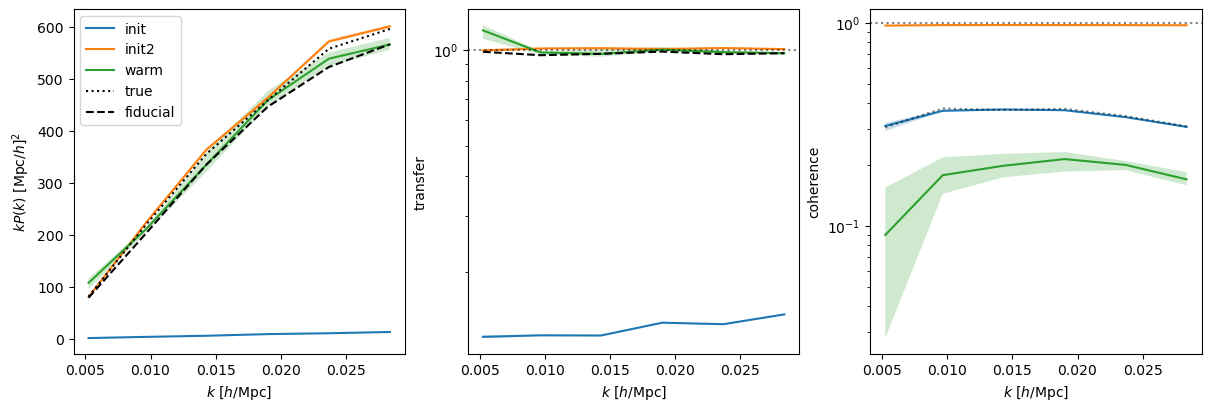

In [6]:
prob = 0.95

plt.figure(figsize=(12, 4), layout='constrained')
def plot_kptcs(kptcs, label=None):
    plot_powtranscoh(*kptcs, fill=prob)
    plot_powtranscoh(*tree.map(lambda x: jnp.median(x, 0), kptcs), label=label)

plot_kptcs(kptcs_init, label='init')
plot_kptcs(kptcs_init2, label='init2')
plot_kptcs(kptcs_warm, label='warm')

plt.subplot(131)
plot_pow(*kpow_true, 'k:', label='true')
plot_pow(*kpow_fid, 'k--', label='fiducial')
plt.legend()
plt.subplot(132)
plot_trans(kpow_true[0], (kpow_fid[1] / kpow_true[1])**.5, 'k--', label='fiducial')
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.subplot(133)
plot_coh(kptc_obs[0], kptc_obs[3], 'k:', alpha=0.5, label='obs');
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.savefig(save_path+f'_init_warm.png')   

### Warmup all parameters and run

In [ ]:
params_warm['init_mesh_']  = jnp.broadcast_to(truth['init_mesh_'], jnp.shape(params_warm['init_mesh_']))

In [ ]:
# jconfig.update("jax_debug_nans", True)
from tqdm import tqdm
from montecosmo.samplers import get_mclmc_warmup, get_mclmc_run
from blackjax.adaptation.mclmc_adaptation import MCLMCAdaptationState
overwrite = True
# overwrite = False


if not os.path.exists(save_path+"_warm2_state.p") or overwrite:
    print("Warming up...")
    warmup_fn = jit(vmap(get_mclmc_warmup(model.logpdf, n_steps=2**14, config=None, # 2**13
                                        desired_energy_var=3e-7, diagonal_preconditioning=tune_mass)))
    state, config = warmup_fn(jr.split(jr.key(43), n_chains), params_warm)

    eval_per_ess = 1e3
    ss = jnp.median(config.step_size)
    config = MCLMCAdaptationState(L=0.4 * eval_per_ess/2 * ss, 
                                step_size=ss, 
                                inverse_mass_matrix=jnp.median(config.inverse_mass_matrix, 0))
    config = tree.map(lambda x: jnp.broadcast_to(x, (n_chains, *jnp.shape(x))), config)
    
    print("ss: ", config.step_size)
    print("L: ", config.L)
    from jax.flatten_util import ravel_pytree
    flat, unrav_fn = ravel_pytree(tree.map(lambda x:x[0], state.position))
    print("inv_mm:", unrav_fn(config.inverse_mass_matrix[0]))
    print(tree.map(vmap(lambda x: jnp.isnan(x).sum()), state.position))

    pdump(state, save_path+"_warm2_state.p")
    pdump(config, save_path+"_conf.p")
    start = 1
    

elif not os.path.exists(save_path+"_last_state.p") or overwrite:
    state = pload(save_path+"_warm2_state.p")
    config = pload(save_path+"_conf.p")
    start = 1

else:
    state = pload(save_path+"_last_state.p")
    config = pload(save_path+"_conf.p")
    start = 100 ###########


print("Running...")
run_fn = jit(vmap(get_mclmc_run(model.logpdf, n_samples, thinning=64, progress_bar=False)))
key = jr.key(42)

end = start + n_runs - 1
for i_run in tqdm(range(start, end + 1)):
    print(f"run {i_run}/{end}")
    key, run_key = jr.split(key, 2)
    state, samples = run_fn(jr.split(run_key, n_chains), state, config)
    
    print("MSE per dim:", jnp.mean(samples['mse_per_dim'], 1), '\n')
    jnp.savez(save_path+f"_{i_run}.npz", **samples)
    pdump(state, save_path+"_last_state.p")



Warming up...


2025-05-27 09:13:02.804388: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit__unnamed_function_] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-05-27 09:15:39.695832: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m36.891525791s

********************************
[Compiling module jit__unnamed_function_] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Perform 14043.0 adaptation steps


  9%|▉         | 6/64 [1:38:45<15:29:13, 961.28s/it]

run 7/64
MSE per dim: [1.10119960e-07 1.18798870e-07 1.20810091e-07 1.30263428e-07
 1.10261042e-07 1.16452756e-07 1.14986386e-07 1.16596541e-07] 



 11%|█         | 7/64 [1:54:32<15:08:59, 956.84s/it]

run 8/64


In [ ]:
config = pload(save_path+"_conf.p")
state = pload(save_path+"_last_state.p")

print("ss: ", config.step_size)
print("L: ", config.L)
from jax.flatten_util import ravel_pytree
flat, unrav_fn = ravel_pytree(tree.map(lambda x:x[0], state.position))
print("inv_mm:", unrav_fn(config.inverse_mass_matrix[0]))